# Find the best way to classify the un-labelled data from the mtl Trajet application

### Initialization cells

In [49]:
#%reset # Clears all variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10,10)

# Load the data
%run "E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/load_mtlTrajet_data.py"

### Reference

#### A key for the modes of transit and purposes of displacements:

##### Mode of transport:
    "pedestrian"
    "cyclist"
    "publicTransit"
    "otherCombo"
##### Purpose:
    "toHome"
    "toWork"        
    "leisure" 
    "errand" 
    "mealSnackCafe" 
    "foodDrink"        
    "childDropoffPickup" 
    "school"        
    "health"

#### Some notes on PCA vs LDA:

    - Both are linear transformation models. 
    - PCA yields the directions (PCs) that maximize variance.
    - LDA aims to find direction that maximizes discrimination between different classes, and is therefore usefull in pattern recognition
    From the plotly documentation:
        "In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes."

### Data processing

Create a matrix and associated vector of IDs for trajectories that don't have a label. Use the trajet_final data, since there is more metadata easily accessible.

##### Test first that there are blanks being properly read with the "" string
Should reflect that there are ~80% uncategorized

In [51]:
blankCount=0
countNotNone=0
cycCount=0
pedCount=0
pubCount=0
carCount=0
othCount=0

for nTraj in range(0,numIds):
    if trip_final["features"][nTraj]["geometry"] is not None: 
        countNotNone=countNotNone+1 # Don't want to consider these for the analysis
            
        if mode[nTraj]=="cyclist":
            cycCount=cycCount+1
        if mode[nTraj]=="pedestrian":
            pedCount=pedCount+1
        if mode[nTraj]=="publicTransit":
            pubCount=pubCount+1
        if mode[nTraj]=="Automobile": # this capitalization will surely be confusing down the line..
            carCount=carCount+1
        if mode[nTraj]=="otherCombo":
            othCount=othCount+1
        if mode[nTraj] is None:     #=="None":
            blankCount=blankCount+1       

print(blankCount)
print(countNotNone)
print(blankCount/numIds)
print(blankCount/countNotNone)

218379
276418
0.7444823236627689
0.7900317634886296


Also added in counts for the seperate modes of transit so I can preallocate the np.arrays

#### Extract the relevant information for each trajectory. 
Make necessary calculation on tempArray of coordinates. 

In [52]:
# Create array to store info for each trajectory. 5 Dimensions corresponding to:
# 0: trajectory ID - will probably be usefull.. 
# 1: average velocity
# 2: euclidean distance
# 3: cummulative distance
# 4: 
extractData_all=np.empty((countNotNone,4)) 
extractData_nil=np.empty((blankCount,4)) 
extractData_cyc=np.empty((cycCount,4)) 
extractData_ped=np.empty((pedCount,4)) 
extractData_pub=np.empty((pubCount,4)) 
extractData_car=np.empty((carCount,4)) 
extractData_oth=np.empty((othCount,4)) 

# Restart the counts, to properly index the np.arrays
blankCount=0
countNotNone=0
cycCount=0
pedCount=0
pubCount=0
carCount=0
othCount=0

for nTraj in range(0,numIds):
    if trip_final["features"][nTraj]["geometry"] is not None: 
        
        tempArray=[]
        tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
        
        # Calculate the total length and euclidean distance for each set of coordinates.
        
        # Euclidean distance "as the crow flies" 
        ncoords=int(tempArray.size/2)
        x1=tempArray[0,0]
        y1=tempArray[0,1]
        x2=tempArray[ncoords-1,0]
        y2=tempArray[ncoords-1,1]
        eucdist = np.sqrt(np.power((x2-x1),2) + np.power((y2-y1),2))  #Import math, need to use numpy?

        # Cummulative length of segments
        sumdist=0
        for i in range(1,ncoords): # Start at 1 because will index zeroth in distance calc
            x1=tempArray[i-1,0]
            y1=tempArray[i-1,1]
            x2=tempArray[i,0]
            y2=tempArray[i,1]
            currdist=np.sqrt(np.power((x2-x1),2) + np.power((y2-y1),2))
            sumdist=sumdist+currdist
            
        # Populate the array of extracted data
        # Warning, if index out of bounds, may be because counts re-zeroed
        extractData_all[countNotNone,0]=ids[nTraj]
        extractData_all[countNotNone,1]=avgSpeed[nTraj]
        extractData_all[countNotNone,2]=eucdist
        extractData_all[countNotNone,3]=sumdist
        countNotNone=countNotNone+1 # Don't want to consider these for the analysis
        
        if mode[nTraj]=="cyclist":
            extractData_cyc[cycCount,0]=ids[nTraj]
            extractData_cyc[cycCount,1]=avgSpeed[nTraj]
            extractData_cyc[cycCount,2]=eucdist
            extractData_cyc[cycCount,3]=sumdist          
            cycCount=cycCount+1
        if mode[nTraj]=="pedestrian":
            extractData_ped[pedCount,0]=ids[nTraj]
            extractData_ped[pedCount,1]=avgSpeed[nTraj]
            extractData_ped[pedCount,2]=eucdist
            extractData_ped[pedCount,3]=sumdist              
            pedCount=pedCount+1
        if mode[nTraj]=="publicTransit":
            extractData_pub[pubCount,0]=ids[nTraj]
            extractData_pub[pubCount,1]=avgSpeed[nTraj]
            extractData_pub[pubCount,2]=eucdist
            extractData_pub[pubCount,3]=sumdist              
            pubCount=pubCount+1
        if mode[nTraj]=="Automobile":
            extractData_car[carCount,0]=ids[nTraj]
            extractData_car[carCount,1]=avgSpeed[nTraj]
            extractData_car[carCount,2]=eucdist
            extractData_car[carCount,3]=sumdist              
            carCount=carCount+1
        if mode[nTraj]=="otherCombo": 
            extractData_oth[othCount,0]=ids[nTraj]
            extractData_oth[othCount,1]=avgSpeed[nTraj]
            extractData_oth[othCount,2]=eucdist
            extractData_oth[othCount,3]=sumdist             
            othCount=othCount+1
        if mode[nTraj] is None:   
            extractData_nil[blankCount,0]=ids[nTraj]
            extractData_nil[blankCount,1]=avgSpeed[nTraj]
            extractData_nil[blankCount,2]=eucdist
            extractData_nil[blankCount,3]=sumdist                
            blankCount=blankCount+1            
     



#### Ideas for followup:

 - Using trip duration, distance and euclidean distance, can we detect a different between modes of transport with respect to how direct they are?

##### Take a look at how the different groups behave considering only the speed and distance

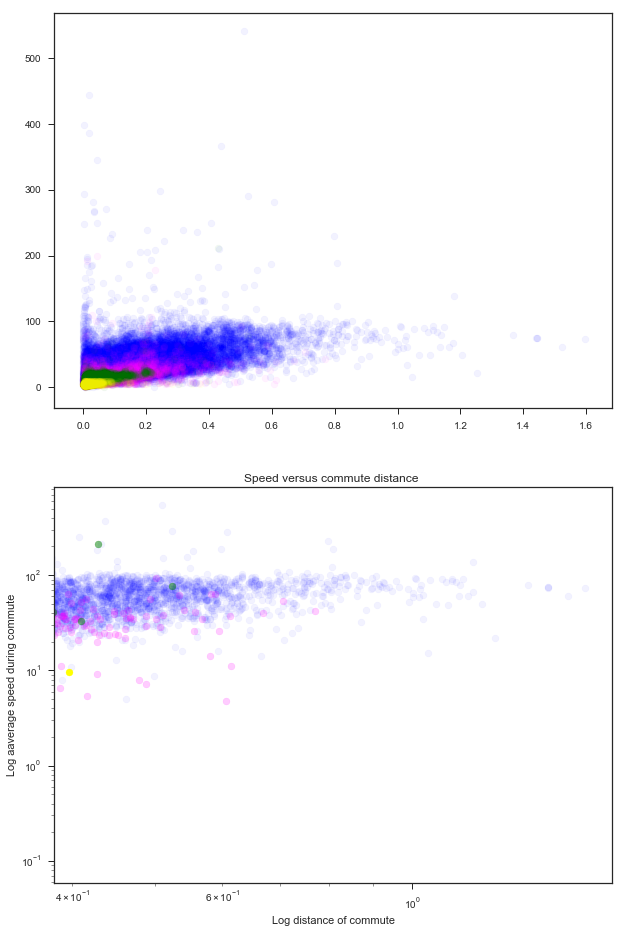

In [53]:
matplotlib.rcParams["figure.figsize"] = (10,16)
fig1, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.scatter(extractData_car[:,3],extractData_car[:,1], c='blue',alpha=0.05) # plot cars first..
ax1.scatter(extractData_pub[:,3],extractData_pub[:,1], c='magenta',alpha=0.05)
ax1.scatter(extractData_cyc[:,3],extractData_cyc[:,1], c='green',alpha=0.05)
ax1.scatter(extractData_ped[:,3],extractData_ped[:,1], c='yellow',alpha=0.05)

plt.title('Speed versus commute distance ')
plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')

ax2.scatter(extractData_car[:,3],extractData_car[:,1], c='blue',alpha=0.05) # plot cars first..
ax2.scatter(extractData_pub[:,3],extractData_pub[:,1], c='magenta',alpha=0.2)
ax2.scatter(extractData_cyc[:,3],extractData_cyc[:,1], c='green',alpha=0.5)
ax2.scatter(extractData_ped[:,3],extractData_ped[:,1], c='yellow',alpha=1)

ax2.set_yscale('log')
ax2.set_xscale('log')

plt.xlabel('Log distance of commute')
plt.ylabel('Log aaverage speed during commute')



plt.show()

This graph is unsatisfactory, and smaller points won't solve everything. It will be usefull to try several other plotting options, including:
    - Datashader, to better see the distribution of points.
    - Contour/Relief plots or violin diagrams for a single factor. 
##### Of note:
    - The variation in pedestrian speed is so small compared to the other modes of transit, that all pedestrians appear within the size of a single point on the log/log scatter.

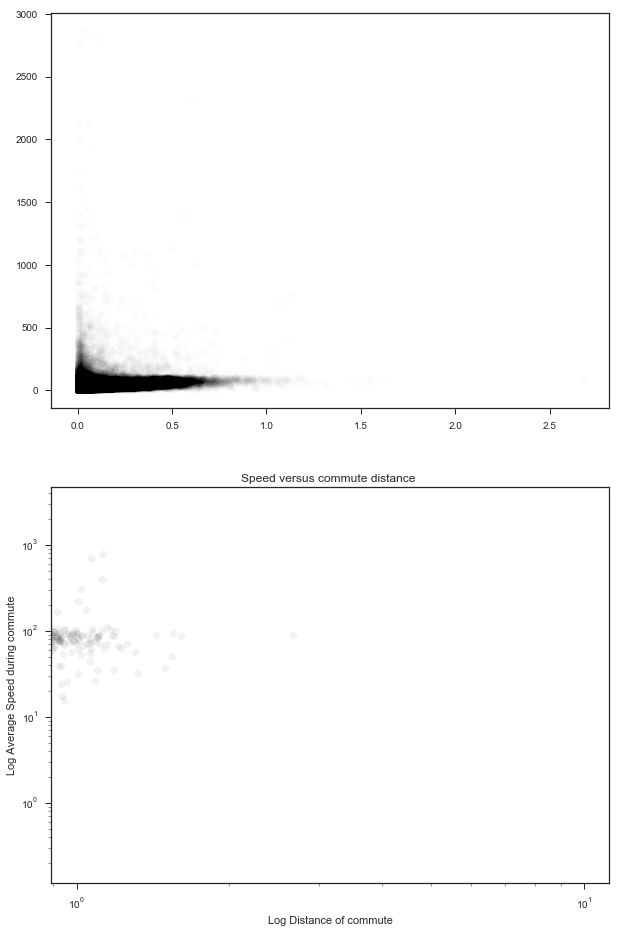

In [54]:
#matplotlib.rcParams["figure.figsize"] = (10,10)
fig2, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,16))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Speed versus commute distance ')
ax1.scatter(extractData_nil[:,3],extractData_nil[:,1], c='black',alpha=0.01) 


ax2.scatter(extractData_nil[:,3],extractData_nil[:,1], c='black',alpha=0.05)
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel('Log Distance of commute')
plt.ylabel('Log Average Speed during commute')

plt.show()

Comparing the graphs in figures 1 and 2 introduces the categorization problem. We can see how easily pedestrians and cyclists can be seperated from cars (within what I expect would be tolerable error). However, there is so much overlap between public transit and cars that we'll need more advanced methods to categorize the unlabelled data.

Of note: 
    - There don't seem to be any data points at a speed of 10, does this mean none of the unlabelled datapoints were pedestrians?

### Alternative visualizations of the categorical data

#####  few new imports

In [55]:
import seaborn as sns

##### Violin plot to see shape of distributions (Python plot gallery OR seaborn)
http://seaborn.pydata.org/examples/elaborate_violinplot.html

##### 2D density plot (Python plot gallery)

##### KDE plots with marginal histograms (seaborn)
http://seaborn.pydata.org/examples/hexbin_marginals.html
This would look nice for each individual mode of transit (4 subplots)

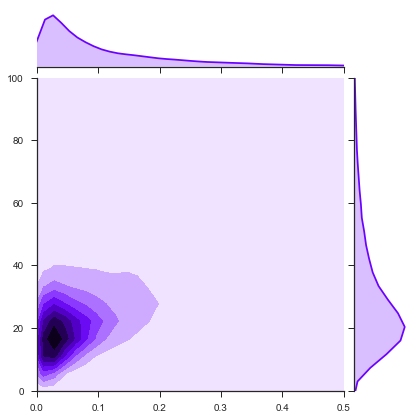

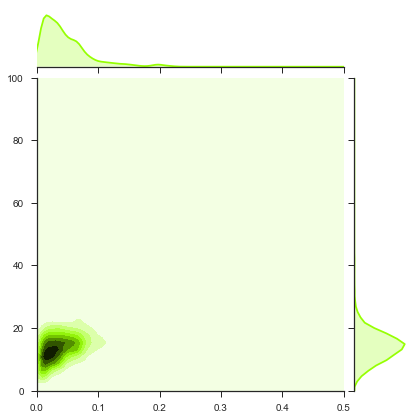

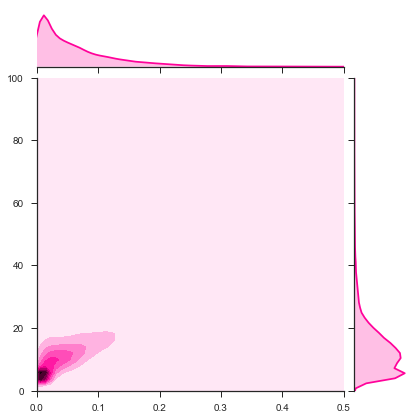

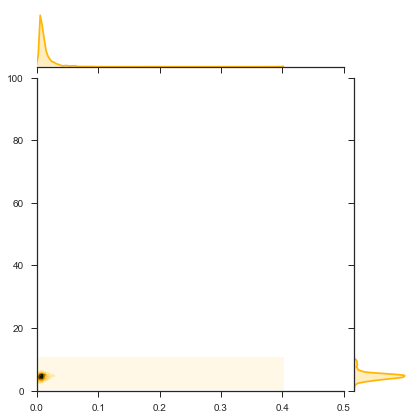

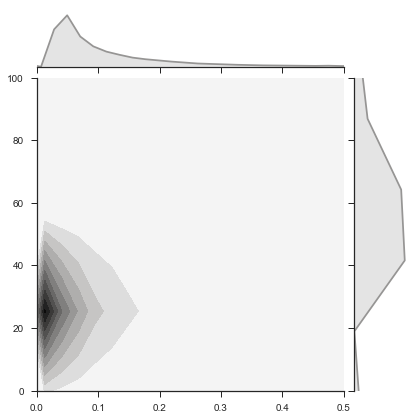

In [56]:
sns.set(style="ticks")

sns.jointplot(extractData_car[:,3], extractData_car[:,1], kind="kde",  
                xlim=[0, 0.5], ylim=[0, 100], stat_func=None, color="#6b02ff")
 
sns.jointplot(extractData_cyc[:,3], extractData_cyc[:,1], kind="kde",  
                xlim=[0, 0.5], ylim=[0, 100], stat_func=None, color="#96ff02")

sns.jointplot(extractData_pub[:,3], extractData_pub[:,1], kind="kde",  
                xlim=[0, 0.5], ylim=[0, 100], stat_func=None, color="#ff029a")

sns.jointplot(extractData_ped[:,3], extractData_ped[:,1], kind="kde",  
                xlim=[0, 0.5], ylim=[0, 100], stat_func=None, color="#ffb702")

sns.jointplot(extractData_nil[:,3], extractData_nil[:,1], kind="kde",  
                xlim=[0, 0.5], ylim=[0, 100], stat_func=None, color="#969594")

##### Note: 
    
    The distributions don't line up correctly with what's plotted. Have the values been changed in one place but not another? (mostly a problem with the final plot..)

Unfortunately, the marginal distributions don't allow columns and rows of subplots, so each figure had to be made individually.

Do a quick test to see if it's possible to have them all on the same axis!

##### Multi-bivariate KDE plots (seaborn)

(0, 41)

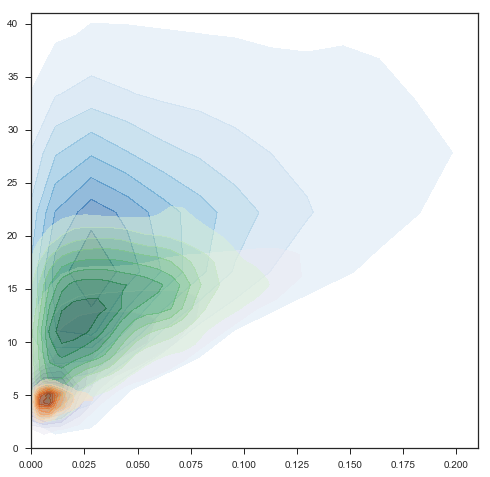

In [57]:
sns.set(style="ticks")




# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(extractData_car[:,3], extractData_car[:,1],cmap="Blues", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(extractData_pub[:,3], extractData_pub[:,1],cmap="Purples", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(extractData_cyc[:,3], extractData_cyc[:,1],cmap="Greens", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(extractData_ped[:,3], extractData_ped[:,1],cmap="Oranges", 
                 shade=True, shade_lowest=False, alpha=0.5)

# Add labels to the plot
#red = sns.color_palette("Reds")[-2]
#blue = sns.color_palette("Blues")[-2]
#ax.text(3.8, 4.5, "Cars", size=16, color=red)
#ax.text(2.5, 8.2, "Cyclists", size=16, color=blue)
ax.set_xlim((0,0.21))
ax.set_ylim((0,41))
#plt.ylim((25,250))


##### Overlapping densities (seaborn)

[ 0.526889    0.24993751  0.20392964  0.01924384]
[[-1.14479527 -1.27876668 -0.16208252 -0.02745414]
 [-0.29519292 -1.30671609 -0.30438843  0.02841119]
 [-0.75106091 -1.01988099  0.02249351 -0.07979798]
 ..., 
 [-1.03770661  1.56099406 -0.31094143 -0.04679554]
 [-0.70747485  1.04057928 -0.1869936  -0.03891433]
 [-0.16103846 -1.68648951  0.14908688  0.04280571]]


(array([  2.56674000e+05,   1.60570000e+04,   3.23300000e+03,
          3.82000000e+02,   5.50000000e+01,   6.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          4.00000000e+00]),
 array([ -1.23253486,   2.21272617,   5.65798721,   9.10324824,
         12.54850927,  15.99377031,  19.43903134,  22.88429238,
         26.32955341,  29.77481444,  33.22007548]),
 <a list of 10 Patch objects>)

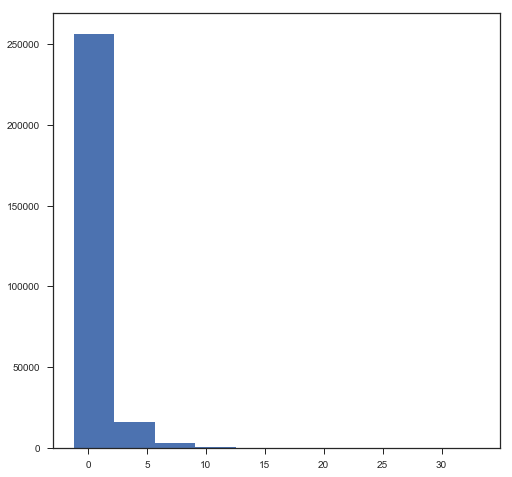

In [58]:
f2, (ax1) = plt.subplots( figsize=(8, 8))
from matplotlib.mlab import PCA

pca_results = PCA(extractData_all)
print(pca_results.fracs)
print(pca_results.Y)
#type(pca_results.Y)
ax1.hist(pca_results.Y[:,0])

#ax.imshow(pca_results.Y)

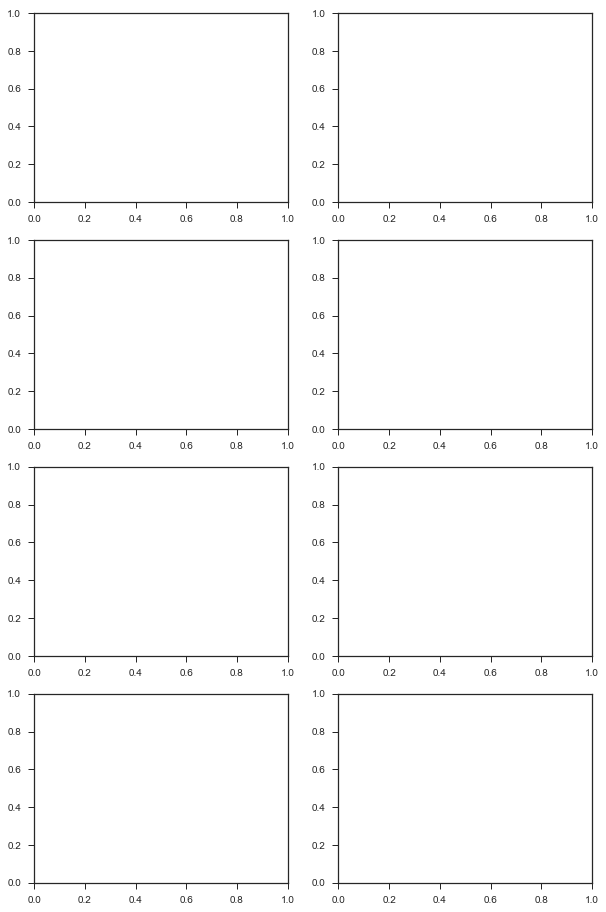

In [59]:

from sklearn.preprocessing import StandardScaler

f2, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(10, 16))

X_std = StandardScaler().fit_transform(extractData_all[:,1:3])
# ax1.hist(extractData_all[:,0], 40)

# ax2.hist(X_std[:,0], 40)
# ax3.hist(extractData_all[:,1], 40)
# ax4.hist(X_std[:,1], 40)
# ax4.set_xlim((-3,3))
# ax5.hist(extractData_all[:,2], 40)
# ax6.hist(X_std[:,2], 40)
# ax6.set_xlim((-3,3))
# ax7.hist(extractData_all[:,3], 40)
# ax8.hist(X_std[:,3], 40)
# ax8.set_xlim((-3,3))

#print(extractData_all)
#print(X_std)
#sklearn_pca = sklearnPCA(n_components=2)
#Y_sklearn = sklearn_pca.fit_transform(X_std)

## Perform PCA

#### Test PCA(matplotlib) on entire data set (without categories)

[ 0.70228772  0.27204951  0.02566277]
[[-1.11265886  0.22389862 -0.03224827]
 [-0.26276857  0.36724039  0.02358047]
 [-0.72532677  0.02696006 -0.08364855]
 ..., 
 [-1.07670579  0.23531033 -0.04093138]
 [-0.73344666  0.13660367 -0.0350104 ]
 [-0.11869716 -0.06737285  0.03645783]]


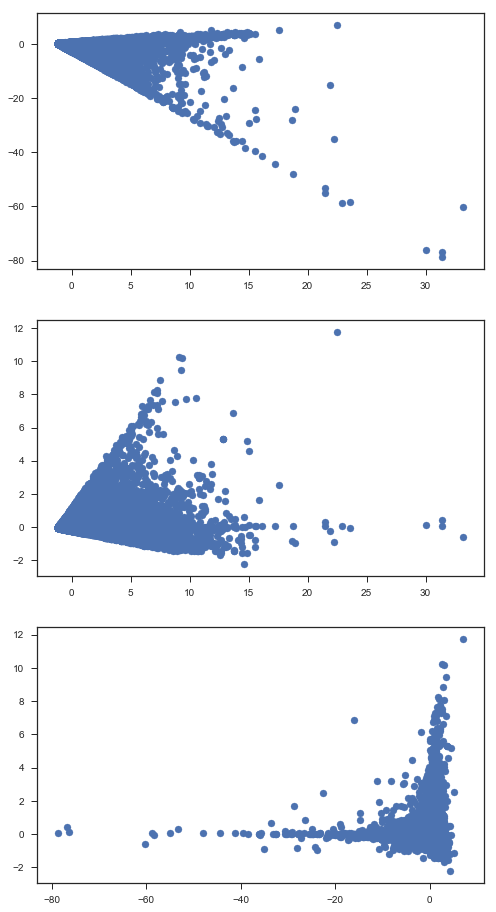

In [60]:
from matplotlib.mlab import PCA
from sklearn.preprocessing import StandardScaler


X_std = StandardScaler().fit_transform(extractData_all[:,1:4])
pca_results = PCA(X_std) 

print(pca_results.fracs) # Gives same values as above, therefore the extra normalization step not necessary
print(pca_results.Y)


f2, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 16))
ax1.scatter(pca_results.Y[:,0],pca_results.Y[:,1])
ax2.scatter(pca_results.Y[:,0],pca_results.Y[:,2])
ax3.scatter(pca_results.Y[:,1],pca_results.Y[:,2])

Hmm, What exactly does this mean...

Do the same PCA as above, but this time maintaining the categories.

- One way would be to use the IDs from each seperate group 

In [61]:
a=extractData_car[:,1:4]
print(np.shape(a))

(34048, 3)


In [62]:
combArray = np.vstack((extractData_car[:,1:4], extractData_pub[:,1:4],
                            extractData_cyc[:,1:4], extractData_ped[:,1:4],
                            extractData_oth[:,1:4]))

iCar_i = 0
iCar_f = extractData_car[:,1].size
iPub_i = iCar_f# + 1
iPub_f = iPub_i + extractData_pub[:,1].size
iCyc_i = iPub_f# + 1
iCyc_f = iCyc_i + extractData_cyc[:,1].size
iPed_i = iCyc_f# + 1
iPed_f = iPed_i + extractData_ped[:,1].size
iOth_i = iPed_f# + 1
iOth_f = iOth_i + extractData_oth[:,1].size


print(np.shape(combArray[iCar_i:iCar_f,:]))
print(np.shape(combArray[iPub_i:iPub_f,:]))
print(np.shape(combArray[iCyc_i:iCyc_f,:]))
print(np.shape(combArray[iPed_i:iPed_f,:]))
print(np.shape(combArray[iOth_i:iOth_f,:]))

(34048, 3)
(12720, 3)
(3831, 3)
(3958, 3)
(1389, 3)


In [63]:
print(np.shape(extractData_car[:,1:4]))
print(np.shape(extractData_pub[:,1:4]))
print(np.shape(extractData_cyc[:,1:4]))
print(np.shape(extractData_ped[:,1:4]))
print(np.shape(extractData_oth[:,1:4]))

(34048, 3)
(12720, 3)
(3831, 3)
(3958, 3)
(1389, 3)


In [64]:
print(np.shape(combArray))
print( extractData_car[:,0].size)
test = extractData_car[:,0].size +  extractData_ped[:,0].size +  extractData_pub[:,0].size + extractData_cyc[:,0].size +  extractData_oth[:,0].size
print(test)


(55946, 3)
34048
55946


#### Matplotlib PCA

In [65]:
from matplotlib.mlab import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(combArray)
pca_results = PCA(X_std)

##### Plot the categories with respect to principal components

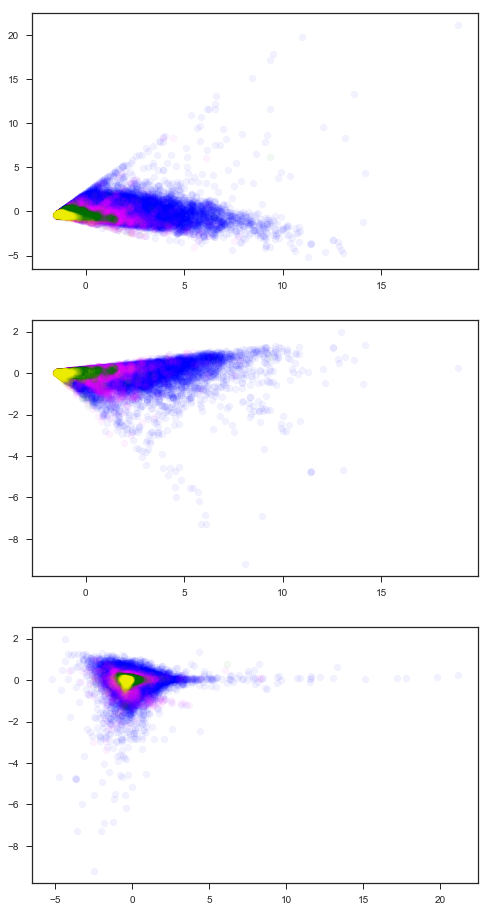

In [66]:
f2, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 16))

ax1.scatter(pca_results.Y[iCar_i:iCar_f,0],pca_results.Y[iCar_i:iCar_f,1], color='blue', alpha=0.05)
ax1.scatter(pca_results.Y[iPub_i:iPub_f,0],pca_results.Y[iPub_i:iPub_f,1], color='magenta', alpha=0.05)
ax1.scatter(pca_results.Y[iCyc_i:iCyc_f,0],pca_results.Y[iCyc_i:iCyc_f,1], color='green', alpha=0.05)
ax1.scatter(pca_results.Y[iPed_i:iPed_f,0],pca_results.Y[iPed_i:iPed_f,1], color='yellow', alpha=0.05)
#ax1.scatter(pca_results.Y[iOth_i:iOth_f,0],pca_results.Y[iOth_i:iOth_f,1], color='cyan')

ax2.scatter(pca_results.Y[iCar_i:iCar_f,0],pca_results.Y[iCar_i:iCar_f,2], color='blue', alpha=0.05)
ax2.scatter(pca_results.Y[iPub_i:iPub_f,0],pca_results.Y[iPub_i:iPub_f,2], color='magenta', alpha=0.05)
ax2.scatter(pca_results.Y[iCyc_i:iCyc_f,0],pca_results.Y[iCyc_i:iCyc_f,2], color='green', alpha=0.05)
ax2.scatter(pca_results.Y[iPed_i:iPed_f,0],pca_results.Y[iPed_i:iPed_f,2], color='yellow', alpha=0.05)
#ax2.scatter(pca_results.Y[iOth_i:iOth_f,0],pca_results.Y[iOth_i:iOth_f,2], color='cyan')

ax3.scatter(pca_results.Y[iCar_i:iCar_f,1],pca_results.Y[iCar_i:iCar_f,2], color='blue', alpha=0.05)
ax3.scatter(pca_results.Y[iPub_i:iPub_f,1],pca_results.Y[iPub_i:iPub_f,2], color='magenta', alpha=0.05)
ax3.scatter(pca_results.Y[iCyc_i:iCyc_f,1],pca_results.Y[iCyc_i:iCyc_f,2], color='green', alpha=0.05)
ax3.scatter(pca_results.Y[iPed_i:iPed_f,1],pca_results.Y[iPed_i:iPed_f,2], color='yellow', alpha=0.05)
#ax3.scatter(pca_results.Y[iOth_i:iOth_f,1],pca_results.Y[iOth_i:iOth_f,2], color='cyan')

(-0.75, 0.75)

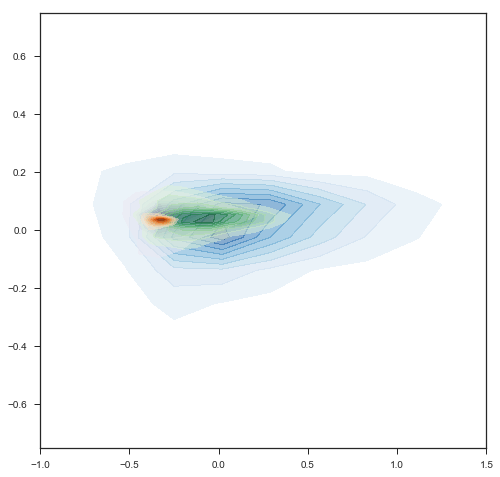

In [67]:
sns.set(style="ticks")
#f3, ((ax1), (ax2), (ax3)) = plt.subplots(3,1, figsize=(8, 16))
f3, (ax3) = plt.subplots(figsize=(8, 8))

# Set up the figure

# # Draw the multiple density plots for Subplot 1
# ax1 = sns.kdeplot(pca_results.Y[iCar_i:iCar_f,0], pca_results.Y[iCar_i:iCar_f,1],cmap="Blues", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax1 = sns.kdeplot(pca_results.Y[iPub_i:iPub_f,0], pca_results.Y[iPub_i:iPub_f,1],cmap="Purples", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax1 = sns.kdeplot(pca_results.Y[iCyc_i:iCyc_f,0], pca_results.Y[iCyc_i:iCyc_f,1],cmap="Greens", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax1 = sns.kdeplot(pca_results.Y[iPed_i:iPed_f,0], pca_results.Y[iPed_i:iPed_f,1],cmap="Oranges", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax1.set_xlim((-2,2))
# ax1.set_ylim((-2,2))


# # Draw the multiple density plots for Subplot 2
# ax2 = sns.kdeplot(pca_results.Y[iCar_i:iCar_f,0], pca_results.Y[iCar_i:iCar_f,2],cmap="Blues", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax2 = sns.kdeplot(pca_results.Y[iPub_i:iPub_f,0], pca_results.Y[iPub_i:iPub_f,2],cmap="Purples", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax2 = sns.kdeplot(pca_results.Y[iCyc_i:iCyc_f,0], pca_results.Y[iCyc_i:iCyc_f,2],cmap="Greens", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax2 = sns.kdeplot(pca_results.Y[iPed_i:iPed_f,0], pca_results.Y[iPed_i:iPed_f,2],cmap="Oranges", 
#                  shade=True, shade_lowest=False, alpha=0.5)
# ax2.set_xlim((-2,2))
# ax2.set_ylim((-2,2))


# Draw the multiple density plots for Subplot 3
ax3 = sns.kdeplot(pca_results.Y[iCar_i:iCar_f,1], pca_results.Y[iCar_i:iCar_f,2],cmap="Blues", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax3 = sns.kdeplot(pca_results.Y[iPub_i:iPub_f,1], pca_results.Y[iPub_i:iPub_f,2],cmap="Purples", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax3 = sns.kdeplot(pca_results.Y[iCyc_i:iCyc_f,1], pca_results.Y[iCyc_i:iCyc_f,2],cmap="Greens", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax3 = sns.kdeplot(pca_results.Y[iPed_i:iPed_f,1], pca_results.Y[iPed_i:iPed_f,2],cmap="Oranges", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax3.set_xlim((-1,1.5))
ax3.set_ylim((-0.75,0.75))






#### Scikit learn PCA

[ 0.81990156  0.15559012  0.02450832]
[ 370.95907945  161.59806381   64.13600507]
[[-0.32628696 -0.44681302 -0.54293516]
 [-0.6920605  -0.67715733 -0.69866943]
 [-0.86418923 -0.75052827 -0.61133579]
 ..., 
 [-1.00404381 -0.68537539 -0.71041155]
 [-0.98252772 -0.70941172 -0.76038703]
 [-0.53068982 -0.07984258 -0.17286925]]
[[ 0.517265    0.60485641  0.60546317]
 [ 0.85581636 -0.36880516 -0.36271354]
 [-0.00390833 -0.7057843   0.70841601]]


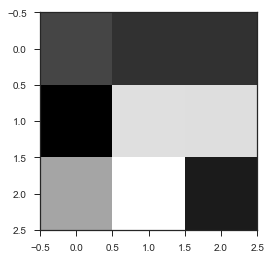

In [68]:
from sklearn.decomposition import PCA #as sklearnPCA

X_std = StandardScaler().fit_transform(combArray)
Y = PCA(X_std)

pca = PCA()
pca.fit(X_std)
pca_score = pca.explained_variance_ratio_
V = pca.components_

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

f4, (ax) = plt.subplots(figsize=(4, 4))
ax.imshow(V, cmap='Greys')

print(Y.n_components)
print(V)

This graph above is the key to understanding all of the plots below. Add the labels and triple check to be sure that you know which PC represents which variable what amount.


In [69]:
type(Y.n_components)

numpy.ndarray

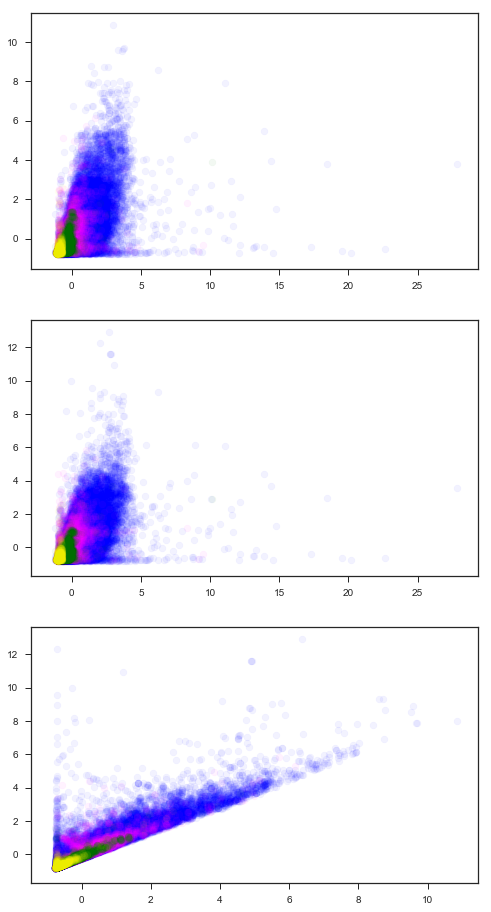

In [70]:
f2, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 16))

ax1.scatter(Y.n_components[iCar_i:iCar_f,0],Y.n_components[iCar_i:iCar_f,1], color='blue', alpha=0.05)
ax1.scatter(Y.n_components[iPub_i:iPub_f,0],Y.n_components[iPub_i:iPub_f,1], color='magenta', alpha=0.05)
ax1.scatter(Y.n_components[iCyc_i:iCyc_f,0],Y.n_components[iCyc_i:iCyc_f,1], color='green', alpha=0.05)
ax1.scatter(Y.n_components[iPed_i:iPed_f,0],Y.n_components[iPed_i:iPed_f,1], color='yellow', alpha=0.05)
#ax1.scatter(pca_results.Y[iOth_i:iOth_f,0],pca_results.Y[iOth_i:iOth_f,1], color='cyan')

ax2.scatter(Y.n_components[iCar_i:iCar_f,0],Y.n_components[iCar_i:iCar_f,2], color='blue', alpha=0.05)
ax2.scatter(Y.n_components[iPub_i:iPub_f,0],Y.n_components[iPub_i:iPub_f,2], color='magenta', alpha=0.05)
ax2.scatter(Y.n_components[iCyc_i:iCyc_f,0],Y.n_components[iCyc_i:iCyc_f,2], color='green', alpha=0.05)
ax2.scatter(Y.n_components[iPed_i:iPed_f,0],Y.n_components[iPed_i:iPed_f,2], color='yellow', alpha=0.05)
#ax2.scatter(pca_results.Y[iOth_i:iOth_f,0],pca_results.Y[iOth_i:iOth_f,2], color='cyan')

ax3.scatter(Y.n_components[iCar_i:iCar_f,1],Y.n_components[iCar_i:iCar_f,2], color='blue', alpha=0.05)
ax3.scatter(Y.n_components[iPub_i:iPub_f,1],Y.n_components[iPub_i:iPub_f,2], color='magenta', alpha=0.05)
ax3.scatter(Y.n_components[iCyc_i:iCyc_f,1],Y.n_components[iCyc_i:iCyc_f,2], color='green', alpha=0.05)
ax3.scatter(Y.n_components[iPed_i:iPed_f,1],Y.n_components[iPed_i:iPed_f,2], color='yellow', alpha=0.05)


## Classification using SciKit-Learn

To begin, use the raw, un-reduced data with a Gaussian Process classifier, as it appears to work the best for 'circular' types of data distributions

Switch out the sample data with the trajectory stats data.

Reference for mode specific indexes

    iCar_i:iCar_f
    iPub_i:iPub_f
    iCyc_i:iCyc_f
    iPed_i:iPed_f
    iOth_i:iOth_f

### Choose the data to fit/test

##### Use the original values of speed and distance

In [71]:
# Combarray already has removed the id number, so indexes not the same as extractData
X=np.stack((combArray[:,0],combArray[:,2]), axis=-1)
y=np.zeros(combArray[:,0].size)

y[iCar_i:iCar_f]=1  # Swap the indexes here to change the mode that's being trained/tested.


##### Alternatively, use the PCA output data (first two principal components)

In [72]:
# Combarray already has removed the id number, so indexes not the same as extractData
# pca_results.Y or Y.n_components (Results from different PCA functions)
X=np.copy(pca_results.Y[:,0:2])
y=np.zeros(combArray[:,0].size)

y[iCyc_i:iCyc_f]=1  # Swap the indexes here to change the mode that's being trained/tested.


##### Some housekeeping

Because my PC froze using the analysis below with the full data set, I suspect that virtual memory may have been limiting. So, the cell below is just to remove any variables I'm not currently needing.

In [73]:
# # del allCoords
# # del allIDs
# # del arrays
# # del arrays2
# # del arrays3
# del avgSpeed
# del blankCount
# del burrShapes
# del burr_name_list
# del burroughPops
# del burrough_array
# del carCount
# del combArray
# del coords_if
# del countNotNone
# del currdist
# del cycCount
# del duration
# del eucdist
# # del extractData_all
# # del extractData_car
# # del extractData_cyc
# # del extractData_nil
# # del extractData_oth
# # del extractData_ped
# # del extractData_pub
# # del f
# # del f2
# # del f3
# # del filepath
# # del filepath2
# # del filepath3
# # del i
# # del iCar_f
# # del iCar_i
# # del iCyc_f
# # del iCyc_i
# # del iOth_f
# # del iOth_i
# # del iPed_f
# # del iPed_i
# # del iPub_f
# # del iPub_i
# del iTot
# del ids
# del j
# del json_data
# del json_filepath
# del k
# del k2
# del k3
# del lenArray
# del lenArray2
# del lenArray3
# del mode
# del nB
# del nBurroughs
# del nTraj
# del ncoords
# del numIds
# del othCount
# del pedCount
# del pubCount
# del purpose
# del sumdist
# del tempArray
# del totNCoords
# del trip_final
# del v
# del v2
# del v3
# del x1
# del x2
# del y1
# del y2


In [75]:
# PyInt_ClearFreeList()

### Fit the model

[[-1.19058023 -0.08912072]
 [-1.27111798 -0.24104881]
 [-0.97219883  0.39479847]
 [-0.71030447 -0.41666273]]
<class 'sklearn.preprocessing.data.StandardScaler'>
()
<class 'sklearn.preprocessing.data.StandardScaler'>
()
[ -1.36555884e-15  -4.75507097e-16]
----
[[-0.7591318  -0.13044489]
 [-0.81048387 -0.35282013]
 [-0.61988854  0.57786159]
 [-0.45290077 -0.60986404]]
----
[[-0.7591318  -0.13044489]
 [-0.81048387 -0.35282013]
 [-0.61988854  0.57786159]
 [-0.45290077 -0.60986404]]
0.932034496626


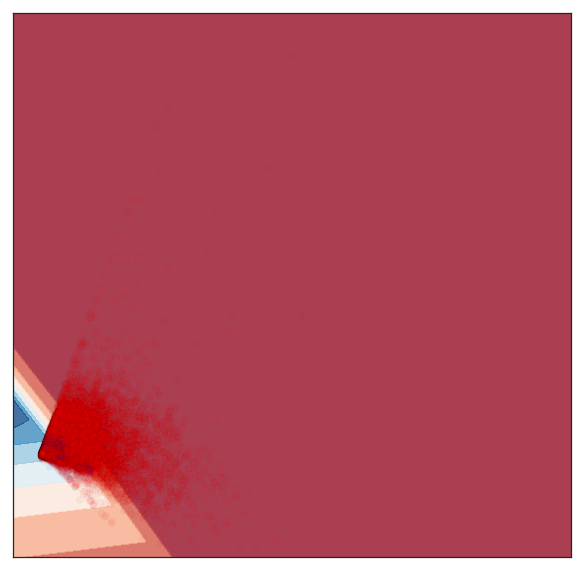

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
# Import a sample dataset to make sure the process runs smoothly in it first
from sklearn.datasets import make_circles

h = .02  # step size in the mesh

# clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf = MLPClassifier(alpha=1)

# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
# First use the sample dataset. Then replace with my data.
# ds= make_circles(noise=0.2, factor=0.5, random_state=1)
# preprocess dataset, split into training and test part
# X, y = ds

#scaler = StandardScaler().fit_transform(X)

scaler_test = StandardScaler().fit_transform(X)
scaler = StandardScaler()
print(X[1:5,:])
print(type(scaler))
print(np.shape(scaler))
X_sc = scaler.fit_transform(X)
print(type(scaler))
print(np.shape(scaler))
print(scaler.mean_)
print("----")
print(X_sc[1:5,:])
print("----")
print(scaler_test[1:5,:])

X_train, X_test, y_train, y_test = \
    train_test_split(X_sc, y, test_size=.4, random_state=42)
    
fig5, ax = plt.subplots(1,figsize=(10, 10))
# Set the meshgrid boundaries for the plot and decision boundaries    
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))    

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# Plot the training points
# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k', alpha=0.05)
# and testing points
# ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.1,
#            edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
    
# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# # Plot also the training points
# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k', alpha=0.05)
# # and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.05)

print(score)

##### Notes and things to try:
    - Doing this on PCA data
    - Creating density plot of the test results.
    - Look at fit on a log scale (?)
    - Compare multiple fit methods (as in the example)
        - Compare them quantitatively 
    - Can we increase the number of categories to 4, instead of doing sequential trainings?
        - Apparently all of the classifiers work for multi-class out of the box.. Just add more labels to y[]
    

Seperate the test results into two groups based on the color in y. 

Text(0.5,1,'Test classification ')

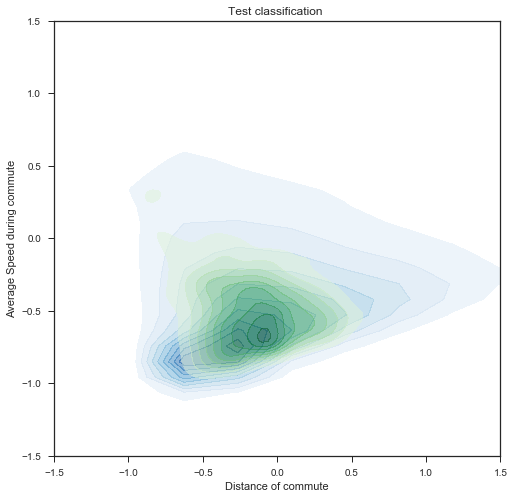

In [77]:
# Split the test results into groups a and b.
group_a = X_test[y_test.astype(bool), :]             # Filter the test results with the boolean array
group_b = X_test[np.invert(y_test.astype(bool)), :]  # Get the remaining results of the test matrix

sns.set(style="ticks")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots 
ax = sns.kdeplot(group_b[:,1], group_b[:,0],cmap="Blues",     # I changed the order to be consistent with scatter plots earlier in notebook
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_a[:,1], group_a[:,0],cmap="Greens", 
                 shade=True, shade_lowest=False, alpha=0.5)


ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Test classification ')


Text(0.5,1,'Training classification ')

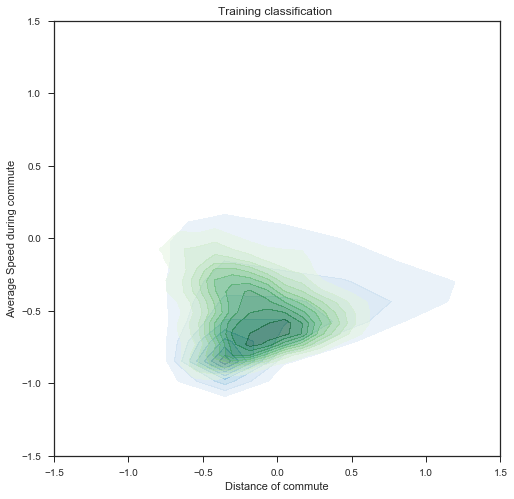

In [78]:
# Split the test results into groups a and b.
group_a = X_train[y_train.astype(bool), :]             # Filter the test results with the boolean array
group_b = X_train[np.invert(y_train.astype(bool)), :]  # Get the remaining results of the test matrix

sns.set(style="ticks")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots 
ax = sns.kdeplot(group_b[:,1], group_b[:,0],cmap="Blues",     # I changed the order to be consistent with scatter plots earlier in notebook
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_a[:,1], group_a[:,0],cmap="Greens", 
                 shade=True, shade_lowest=False, alpha=0.5)


ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Training classification ')


### Apply the model to new data

##### Apply the scaler to the new data (stored in the variable X from the functuon: X = preprocessing.StandardScaler().fit(X))

In [79]:
X_new=np.stack((extractData_nil[:,1],extractData_nil[:,3]), axis=-1) # Indexes different than during classification because I'm getting the values straight from the extractData variable 
X_new_scaled = scaler.transform(X_new)
y_new = clf.predict(X_new_scaled)

(0, 2)


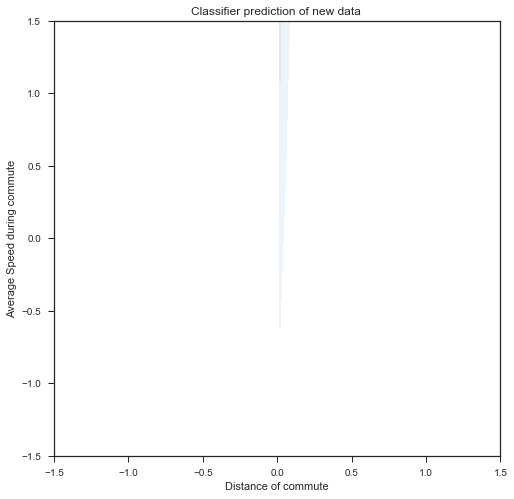

In [80]:
# Split the test results into groups a and b.
group_a = X_new_scaled[y_new.astype(bool), :]             # Filter the test results with the boolean array
group_b = X_new_scaled[np.invert(y_new.astype(bool)), :]  # Get the remaining results of the test matrix

sns.set(style="ticks")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots 
ax = sns.kdeplot(group_b[:,1], group_b[:,0],cmap="Blues",     # I changed the order to be consistent with scatter plots earlier in notebook
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_a[:,1], group_a[:,0],cmap="Greens", 
                 shade=True, shade_lowest=False, alpha=0.5)


ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Classifier prediction of new data ')
print(np.shape(group_a))

### Multi-label classification with Scikit-learn

##### Reference for mode specific indexes

    iCar_i:iCar_f
    iPub_i:iPub_f
    iCyc_i:iCyc_f
    iPed_i:iPed_f
    iOth_i:iOth_f

#### Choose the data to fit/test

##### Use the original values of speed and distance

In [81]:
from sklearn.preprocessing import MultiLabelBinarizer

# Combarray already has removed the id number, so indexes not the same as extractData
X=np.stack((combArray[:,0],combArray[:,2]), axis=-1)
y=np.zeros(combArray[:,0].size)

# Set different classes
y[iCar_i:iCar_f]=1  
y[iPub_i:iPub_f]=2
y[iCyc_i:iCyc_f]=3
y[iPed_i:iPed_f]=4
y[iOth_i:iOth_f]=5


# print(y[0:30])
# print(type(y))
# MultiLabelBinarizer().fit(y.astype(int))
# print(y[0:30,:])

0.68345323741


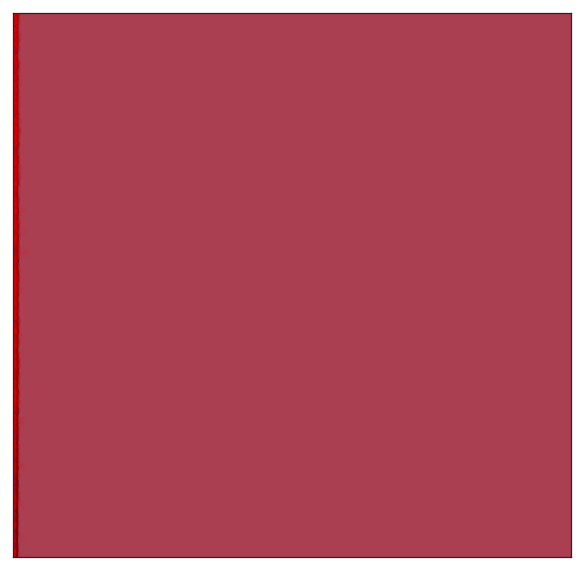

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
# Import a sample dataset to make sure the process runs smoothly in it first
from sklearn.datasets import make_circles

h = .02  # step size in the mesh

# clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf = MLPClassifier(alpha=1)

# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
# First use the sample dataset. Then replace with my data.
# ds= make_circles(noise=0.2, factor=0.5, random_state=1)
# preprocess dataset, split into training and test part
# X, y = ds

#scaler = StandardScaler().fit_transform(X)


scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X_sc, y, test_size=.4, random_state=42)
    
fig5, ax = plt.subplots(1,figsize=(10, 10))
# Set the meshgrid boundaries for the plot and decision boundaries    
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))    

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# Plot the training points
# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k', alpha=0.05)
# and testing points
# ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.1,
#            edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
    
# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# # Plot also the training points
# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k', alpha=0.05)
# # and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.05)

print(score)

##### Separate them into groups

In [83]:
# Split the test results into groups a and b.
# group_a = X_test[y_test.astype(bool), :]             # Filter the test results with the boolean array
# group_b = X_test[np.invert(y_test.astype(bool)), :]  # Get the remaining results of the test matrix

group_a = X_test[np.where(y_test == 1), :]  
print(group_a)

[[[-0.91260043 -0.64377867]
  [-0.26173869 -0.73136079]
  [-0.46076253 -0.43411075]
  ..., 
  [ 0.20623628  0.16013933]
  [-0.18105335  0.04965057]
  [ 1.62091924  2.16830955]]]


In [84]:
# Split the test results into groups a-d (e)
group_a = np.squeeze(X_test[np.where(y_test == 1), :])    # Car
group_b = np.squeeze(X_test[np.where(y_test == 2), :])    # Public transit
group_c = np.squeeze(X_test[np.where(y_test == 3), :])    # Cyclists
group_d = np.squeeze(X_test[np.where(y_test == 4), :])    # Pedestrian
#group_e = np.squeeze(X_test[np.where(y_test == 5), :])     # other combination


print(np.shape(group_a))
print(np.shape(group_b))
print(np.shape(group_c))
print(np.shape(group_d))

(13664, 2)
(5021, 2)
(1521, 2)
(1594, 2)


(13664, 2)
(5021, 2)
(1521, 2)
(1594, 2)


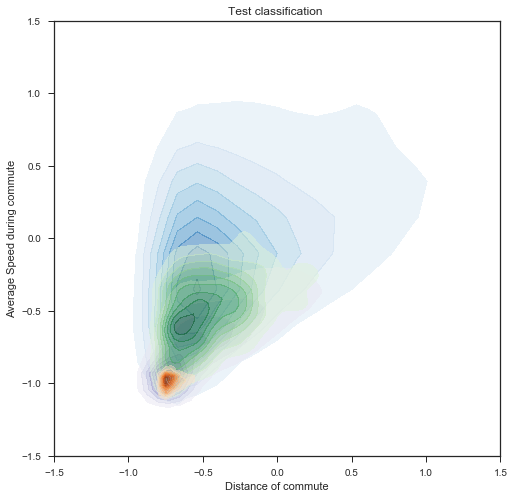

In [85]:
sns.set(style="ticks")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots 
ax = sns.kdeplot(group_a[:,1], group_a[:,0],cmap="Blues",     # I changed the order to be consistent with scatter plots earlier in notebook
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_b[:,1], group_b[:,0],cmap="Purples", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_c[:,1], group_c[:,0],cmap="Greens",    
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_d[:,1], group_d[:,0],cmap="Oranges", 
                 shade=True, shade_lowest=False, alpha=0.5)

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Test classification ')

print(np.shape(group_a))
print(np.shape(group_b))
print(np.shape(group_c))
print(np.shape(group_d))

#### As above, apply the model to new data

In [86]:
X_new=np.stack((extractData_nil[:,1],extractData_nil[:,3]), axis=-1) # Indexes different than during classification because I'm getting the values straight from the extractData variable 
X_new_scaled = scaler.transform(X_new)
y_new = clf.predict(X_new_scaled)

Text(0.5,1,'Classifier prediction of new data ')

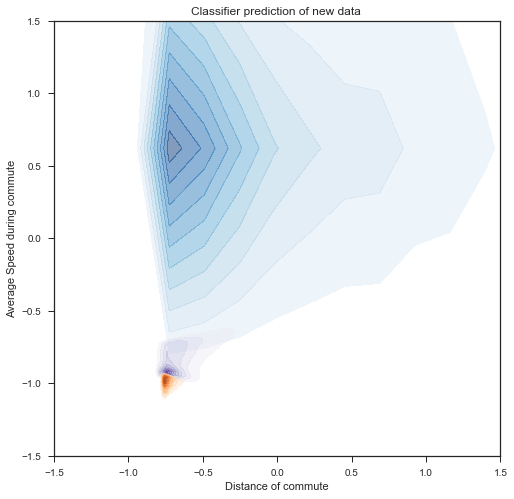

In [87]:
# Split the test results into groups a-d (e)
group_a = np.squeeze(X_new_scaled[np.where(y_new == 1), :])    # Car
group_b = np.squeeze(X_new_scaled[np.where(y_new == 2), :])    # Public transit
group_c = np.squeeze(X_new_scaled[np.where(y_new == 3), :])    # Cyclists
group_d = np.squeeze(X_new_scaled[np.where(y_new == 4), :])    # Pedestrian
#group_e = np.squeeze(X_new_scaled[np.where(y_new == 5), :])     # other combination




sns.set(style="ticks")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the two density plots 
ax = sns.kdeplot(group_a[:,1], group_a[:,0],cmap="Blues",     # I changed the order to be consistent with scatter plots earlier in notebook
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_b[:,1], group_b[:,0],cmap="Purples", 
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_c[:,1], group_c[:,0],cmap="Greens",    
                 shade=True, shade_lowest=False, alpha=0.5)
ax = sns.kdeplot(group_d[:,1], group_d[:,0],cmap="Oranges", 
                 shade=True, shade_lowest=False, alpha=0.5)

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))

plt.xlabel('Distance of commute')
plt.ylabel('Average Speed during commute')
plt.title('Classifier prediction of new data ')


In [88]:
print(np.shape(group_a))
print(np.shape(group_b))
print(np.shape(group_c))
print(np.shape(group_d))

(168994, 2)
(31387, 2)
(0, 2)
(17998, 2)


If this analysis can be trusted, it gives us a lot more data to play with. 163000 more cars, 43000 more public transit, and 11.5k more pedestrians 
(surprisingly there are no categorized bikes... which is a problem. )

    - In order to access the trajectories to use in a visualization, I would need to go back and make sure the IDs are being  sliced and recombined in all the same ways as the other data, namely:
        - extractData_xxx variables still have ID number in the first column.
        - Column was clipped into combArray - using the transit-mode-specific indexes (i.e. iCar_i:iCar_f)
        - However, X_new was taken directly from extractData_nil to be used in the training data, so the indexes obtained using the mask [np.where(y_new == i), :] (where i =1,2,3,4,5) should work equally well to extract the relevant IDs from extractData_nil[:,0].
    

In [89]:
a_ids=np.squeeze(extractData_nil[np.where(y_new == 1),0])
b_ids=np.squeeze(extractData_nil[np.where(y_new == 2),0])
c_ids=np.squeeze(extractData_nil[np.where(y_new == 3),0])
d_ids=np.squeeze(extractData_nil[np.where(y_new == 4),0])

print(np.shape(a_ids))
print(np.shape(b_ids))
print(np.shape(c_ids))
print(np.shape(d_ids))
print("-----------")
print(a_ids[0:20])
print("-----------")
print(b_ids[0:20])
print("-----------")
print(c_ids[0:20])
print("-----------")
print(d_ids[0:20])


(168994,)
(31387,)
(0,)
(17998,)
-----------
[ 3374507.  3444521.  2690388.  3152793.  2336903.  2545586.  2007630.
  1618457.  3024731.  2278777.  2184542.  1645367.  1687684.  2337205.
  2518262.  1608749.  3544147.  2766019.  2816285.  1723073.]
-----------
[ 1692997.  1998815.  3288563.  2665391.  3586292.  2432316.  2033432.
  2871054.  3271392.  3258002.  1965619.  2819478.  2493213.  3113859.
  2320433.  2361267.  2634379.  2884813.  3265894.  1973045.]
-----------
[]
-----------
[ 3070237.  3131106.  2463135.  2892612.  1622841.  3566304.  2513709.
  2734281.  3170066.  3059946.  2813933.  3447139.  1801808.  2291356.
  2692990.  3194369.  3127780.  1723274.  2825734.  2824888.]


##### Make a hexbinned 2d histrogram using the newly 'obtained'  classified data.

In [90]:
 # Find the overlap between the list of coordinates and the ids classified in a specific group.
    # Beginining with Pedestrians (group d) because the number is smaller, and it's easier to judge the output plot.
mask=np.isin(allIDs, a_ids, assume_unique=False)
sharedIDs=allIDs[mask]
print(np.shape(sharedIDs))

NameError: name 'allIDs' is not defined

In [ ]:
# Apply the mask to the coordinates file as well. A little bit trickier in 2D but worked like this earlier in the notebook
print(np.shape(np.squeeze(mask)))
curr_coords = allCoords[np.squeeze(mask.astype(bool)), :]
print(np.shape(curr_coords))

#define x1 and y1 here from the allCoords set. 
x1=np.copy(curr_coords[:,0]) # With the above note in mind, this may be an exception??
y1=np.copy(curr_coords[:,1])

# Remove the nans from the array
x1 = x1[~np.isnan(x1)]
y1 = y1[~np.isnan(y1)]


# Create linear and log histograms to test the output.
xmin = -74
xmax = -73.4
ymin = 45.3
ymax = 45.8

fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10, 16))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb = ax.hexbin(x1, y1, gridsize=1000, cmap='inferno',extent=(xmin, xmax, ymin, ymax),marginals=True)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Classified pedestrians - Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.axis([xmin, xmax, ymin, ymax])

ax = axs[1]
hb = ax.hexbin(x1, y1, gridsize=1000, bins='log', cmap='inferno',extent=(xmin, xmax, ymin, ymax),marginals=True)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Classified pedestrians - With a log color scale  ")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
ax.axis([xmin, xmax, ymin, ymax])

plt.show()

In [ ]:
As an alternative way to visualize the seperation between modes of transit, try using andrews_curves

## Export the categorized data into a format to be useful elsewhere. 

Ideally, it would have the same formatting as the list of trajectories which I'm already using - i.e. A dict  object. 
However ... the dict already contains all of those points. Therefore, it may be more straightforward to use the list of IDs and corresponding labels, when reading through the existing dict (should take far less space in memory)
The list could then be used to:
    - Perform summary statistics for each borough and populate a dataframe
    - Create density plots/hexbins of the seperate data sets. 

In [ ]:
# group_a    # Car
# group_b    # Public transit
# group_c    # Cyclists
# group_d    # Pedestrian

In [95]:
# Save the data
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/categorized_cars.npy', 
        group_a)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/categorized_public.npy', 
        group_b)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/categorized_bikes.npy', 
        group_c)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/categorized_pedestrian.npy', 
        group_d)

# ID lists for the groups


np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_cars.npy', 
        a_ids)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_public.npy', 
        b_ids)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_bikes.npy', 
        c_ids)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_pedestrian.npy', 
        d_ids)

In [4]:
# Load the saved data
a_ids = np.load('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_cars.npy')
b_ids = np.load('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_public.npy')
c_ids = np.load('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_bikes.npy')
d_ids = np.load('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_ids_pedestrian.npy')



In [5]:
#print(np.shape(group_a))
# print(np.shape(group_b))
# print(np.shape(group_c))
# print(np.shape(group_d))

print(np.size(a_ids))

168994


## Test the output

For each mode of transit, create hexbin density plots of the island of Mtl to compare the categorized vs Scikitlearn categorized data. Despite the numbers being far different, the spatial distributions should be similar
- Or alternatively a contour density plot may show this better.
 This would be an interesting test, because the spatial localization was not used in the analysis to label them (althought distance was...).

In [6]:
# Added these values in manually, since they're set to zero in the next cell
n_cyc_traj = 3831
n_car_traj = 34048
n_pub_traj = 12720

n_ped_traj = 3958


The cell below is still necessary, because we have to calculate the cummulative lengths of all trajectories for each mode of transit, in order to preallocate to the correct size


In [7]:
blankCount=0
countNotNone=0
cycCount=0
pedCount=0
pubCount=0
carCount=0
othCount=0

cycCatCount=0
pedCatCount=0
pubCatCount=0
carCatCount=0

for nTraj in range(0,numIds):
    if trip_final["features"][nTraj]["geometry"] is not None: 
        tempArray=[]
        tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:])

        if mode[nTraj]=="cyclist":
            cycCount=cycCount+np.size(tempArray)/2
        if mode[nTraj]=="pedestrian":
            pedCount=pedCount+np.size(tempArray)/2
        if mode[nTraj]=="publicTransit":
            pubCount=pubCount+np.size(tempArray)/2
        if mode[nTraj]=="Automobile": # this capitalization will surely be confusing down the line..
            carCount=carCount+np.size(tempArray)/2  
        if mode[nTraj] is None:     #=="None":
            # If ID on one of the lists
            tempID=trip_final["features"][nTraj]["properties"]["id_trip"]
            if sum(np.isin(a_ids,tempID)):    # Cars
                carCatCount=carCatCount+np.size(tempArray)/2
            elif sum(np.isin(b_ids,tempID)):    # Public transit
                pubCatCount=pubCatCount+np.size(tempArray)/2
            elif sum(np.isin(c_ids,tempID)):    # Cyclists
                cycCatCount=cycCatCount+np.size(tempArray)/2
            elif sum(np.isin(d_ids,tempID)):    # Pedestrians
                pedCatCount=pedCatCount+np.size(tempArray)/2
            else:    # Otherwise... (don't know what this will mean)
                print('Not on any list')


Preallocate the arrays before the big loop.

In [9]:
# Preallocate numpy arrays for the labelled arrays
cycTrajs_lab=np.empty((int(cycCount),2))
pedTrajs_lab=np.empty((int(pedCount),2))
pubTrajs_lab=np.empty((int(pubCount),2))
carTrajs_lab=np.empty((int(carCount),2))

# Preallocate numpy arrays for the categorized arrays (using SciKitLearn)
# cycTrajs_cat=np.empty((np.size(c_ids),2))
# pedTrajs_cat=np.empty((np.size(d_ids),2))
# pubTrajs_cat=np.empty((np.size(b_ids),2))
# carTrajs_cat=np.empty((np.size(a_ids),2))

# This also has to count the total length of all the trajectories..
cycTrajs_cat=np.empty((int(cycCatCount),2))
pedTrajs_cat=np.empty((int(pedCatCount),2))
pubTrajs_cat=np.empty((int(pubCatCount),2))
carTrajs_cat=np.empty((int(carCatCount),2))

In [11]:
print(np.shape(cycTrajs_lab),np.shape(pedTrajs_lab),np.shape(pubTrajs_lab),np.shape(carTrajs_lab))
print(np.shape(cycTrajs_cat),np.shape(pedTrajs_cat),np.shape(pubTrajs_cat),np.shape(carTrajs_cat))

(303969, 2) (94793, 2) (693886, 2) (4477188, 2)
(0, 2) (271093, 2) (1307717, 2) (14950375, 2)


In [12]:
cyc_rowInd=0
ped_rowInd=0
car_rowInd=0
pub_rowInd=0

cyc_cat_rowInd=0
ped_cat_rowInd=0
car_cat_rowInd=0
pub_cat_rowInd=0

for nTraj in range(0,numIds):
    if trip_final["features"][nTraj]["geometry"] is not None: 
        tempArray=[]
        tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
       
        if mode[nTraj]=="cyclist":
            currEnd=int(cyc_rowInd+np.size(tempArray)/2)
            cycTrajs_lab[cyc_rowInd:currEnd, :]=tempArray
            cyc_rowInd=int(currEnd) 
        if mode[nTraj]=="pedestrian":
            currEnd=int(ped_rowInd+np.size(tempArray)/2)
            pedTrajs_lab[ped_rowInd:currEnd, :]=tempArray
            ped_rowInd=int(currEnd) 
        if mode[nTraj]=="publicTransit":
            currEnd=int(pub_rowInd+np.size(tempArray)/2)
            pubTrajs_lab[pub_rowInd:currEnd, :]=tempArray
            pub_rowInd=int(currEnd) 
        if mode[nTraj]=="Automobile": # this capitalization will surely be confusing down the line..
            currEnd=int(car_rowInd+np.size(tempArray)/2)
            carTrajs_lab[car_rowInd:currEnd, :]=tempArray
            car_rowInd=int(currEnd) 
        if mode[nTraj] is None:     #=="None":

            # If ID on one of the lists
            tempID=trip_final["features"][nTraj]["properties"]["id_trip"]
            if sum(np.isin(a_ids,tempID)):    # Cars
                currEnd=int(car_cat_rowInd+np.size(tempArray)/2)
                carTrajs_cat[car_cat_rowInd:currEnd, :]=tempArray
                car_cat_rowInd=int(currEnd) 
            elif sum(np.isin(b_ids,tempID)):    # Public transit
                currEnd=int(pub_cat_rowInd+np.size(tempArray)/2)
                pubTrajs_cat[pub_cat_rowInd:currEnd, :]=tempArray
                pub_cat_rowInd=int(currEnd) 
            elif sum(np.isin(c_ids,tempID)):    # Cyclists
                currEnd=int(cyc_cat_rowInd+np.size(tempArray)/2)
                cycTrajs_cat[cyc_cat_rowInd:currEnd, :]=tempArray
                cyc_cat_rowInd=int(currEnd) 
            elif sum(np.isin(d_ids,tempID)):    # Pedestrians
                currEnd=int(ped_cat_rowInd+np.size(tempArray)/2)
                pedTrajs_cat[ped_cat_rowInd:currEnd, :]=tempArray
                ped_cat_rowInd=int(currEnd) 
            else:    # Otherwise... (don't know what this will mean)
                print('Hope this doesnt print too many times...')
            
    

Save the resulting arrays

In [13]:
# Save the labelled data (seperated by mode of transit)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/lab_coords_cars.npy', 
        carTrajs_lab)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/lab_coords_public.npy', 
        pubTrajs_lab)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/lab_coords_bikes.npy', 
        cycTrajs_lab)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/lab_coords_pedestrian.npy', 
        pedTrajs_lab)

# Save the categorized data (seperated by mode of transit)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_coords_cars.npy', 
        carTrajs_cat)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_coords_public.npy', 
        pubTrajs_cat)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_coords_bikes.npy', 
        cycTrajs_cat)
np.save('E:/Documents/Professional/Jupyter notebooks/Projects/monTrajet/cat_coords_pedestrian.npy', 
        pedTrajs_cat)